# Dependencies

In [1]:
work_dir = "/home/spaka002/NSF_REU_2024/"

In [2]:
import random
# import wandb
import numpy as np
from dotmap import DotMap

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader

import sys
from notebooks.utilities.helper_functions import *

from notebooks.tensor_completion_models.CoSTCo import *
from notebooks.tensor_completion_models.CPD import *
from notebooks.tensor_completion_models.tuckER import *
from notebooks.tensor_completion_models.ETC import *

import matplotlib.pyplot as plt
from sklearn.utils.validation import check_random_state
import tensorly as tl
from torch.nn.init import xavier_normal_

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split, KFold

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

Device: cuda


In [4]:
data_folder = f"{work_dir}classification_datasets/"
meta_data_folder = f"{work_dir}meta_datasets/"

# Load Tensor

In [5]:
# original_tensor = torch.load(f"{meta_data_folder}GB_car_evaluation_709.pt")
# original_tensor = torch.load(f"{meta_data_folder}SVM_spambase_708.pt")
# original_tensor = torch.load(f"{meta_data_folder}FCNN_Spambase_717.pt")
# original_tensor = torch.load(f"{meta_data_folder}FCNN_Glass_717.pt")
# original_tensor = torch.load(f"{meta_data_folder}FCNN_car_evaluation_717.pt")
# original_tensor = torch.load(f"{meta_data_folder}FCNN_car_evaluation_719.pt")
# original_tensor = torch.load(f"{meta_data_folder}RF_Alzheimers_805.pt")

In [6]:
original_tensor = torch.load(f"{meta_data_folder}FCNN_Spambase_717.pt")

print(original_tensor.shape)

original_tensor = original_tensor.permute(3, 0, 1, 2)[:, 1:, 1:, 3:]

print(original_tensor.shape)

torch.Size([6, 6, 9, 8])
torch.Size([8, 5, 5, 6])


In [7]:
# t1 = torch.load(f"{meta_data_folder}dataset_mode/FCNN_805_807/FCNN_alzheimers_disease_data_807_0.5.pt")
# t2 = torch.load(f"{meta_data_folder}dataset_mode/FCNN_805_807/FCNN_diabetes_binary_807_0.014.pt")
# t3 = torch.load(f"{meta_data_folder}dataset_mode/FCNN_805_807/FCNN_healthcare_dataset_807_0.02.pt")
# t4 = torch.load(f"{meta_data_folder}dataset_mode/FCNN_805_807/FCNN_MiniBoone_Particle_ID_805_0.05.pt")

# original_tensor = torch.stack((t1, t2, t3, t4))

# del t1, t2, t3, t4

# original_tensor = original_tensor[:, :, :, 3, :].clone()

In [8]:
# t1 = torch.load(f"{work_dir}meta_datasets/model_mode/RF_car_727.pt")
# t2 = torch.load(f"{work_dir}meta_datasets/model_mode/DT_car_727.pt")
# t3 = torch.load(f"{work_dir}meta_datasets/model_mode/GB_car_728.pt")
# t4 = torch.load(f"{work_dir}meta_datasets/model_mode/ET_car_730.pt")

# tensor1 = torch.stack((t1, t2, t3, t4))

# del t1, t2, t3, t4

# t1 = torch.load(f"{work_dir}meta_datasets/model_mode/RF_glass_728.pt")
# t2 = torch.load(f"{work_dir}meta_datasets/model_mode/DT_glass_728.pt")
# t3 = torch.load(f"{work_dir}meta_datasets/model_mode/GB_glass_728.pt")
# t4 = torch.load(f"{work_dir}meta_datasets/model_mode/ET_glass_730.pt")

# tensor2 = torch.stack((t1, t2, t3, t4))

# del t1, t2, t3, t4

# t1 = torch.load(f"{work_dir}meta_datasets/model_mode/RF_bodyPerformance_731.pt")
# t2 = torch.load(f"{work_dir}meta_datasets/model_mode/DT_bodyPerformance_731.pt")
# t3 = torch.load(f"{work_dir}meta_datasets/model_mode/GB_bodyPerformance_731.pt")
# t4 = torch.load(f"{work_dir}meta_datasets/model_mode/ET_bodyPerformance_731.pt")

# tensor3 = torch.stack((t1, t2, t3, t4))

# del t1, t2, t3, t4

# t1 = torch.load(f"{work_dir}meta_datasets/model_mode/RF_Dermatology_802.pt")
# t2 = torch.load(f"{work_dir}meta_datasets/model_mode/DT_Dermatology_802.pt")
# t3 = torch.load(f"{work_dir}meta_datasets/model_mode/GB_Dermatology_802.pt")
# t4 = torch.load(f"{work_dir}meta_datasets/model_mode/ET_Dermatology_802.pt")

# tensor4 = torch.stack((t1, t2, t3, t4))

# del t1, t2, t3, t4


# original_tensor = torch.stack((tensor1, tensor2, tensor3, tensor4))

# del tensor1, tensor2, tensor3, tensor4

# original_tensor = original_tensor[:, 0, :, :, 0, :].clone()


In [9]:
print(f"Tensor shape: {original_tensor.shape}")
total_cells = 1
for s in original_tensor.shape: total_cells*=s

print(f"{total_cells} total cells in tensor.")

Tensor shape: torch.Size([8, 5, 5, 6])
1200 total cells in tensor.


In [10]:
# torch.mean(original_tensor, dim = (1, 2, 3, 4))

In [11]:
# plt.figure(figsize=(10, 6))
# plt.boxplot([original_tensor[i, :, :, :].flatten() for i in range(4)]);

# Train & Evaluate

In [12]:
num_epochs = 10000
batch_size = 256
lr = 5e-3
wd = 1e-4
val_size = 0.2

num_iterations = 5

portions = [0.005, 0.01, 0.02, 0.03, 0.04, 0.05]

model_type = 'costco'
rank = 25

In [13]:
empty_slice = 7
other_slice_portion = 0.1

In [14]:
completely_random_MAE = list()
not_completely_random_MAE = list()

for portion in portions:

        it_completely_random_MAE = list()
        it_not_completely_random_MAE = list()
        
        print(f"Portion {portion} iteration:", end = " ")
        for it in range(1, num_iterations+1):
                
# __________________________________________________________________________________________________________________________________________________________

                biased_sparse_tensor = warm_start_biased_sampling(t = original_tensor.clone(), 
                                                                  empty_slice = empty_slice, 
                                                                  empty_slice_random_portion = portion,
                                                                  other_portions = other_slice_portion, 
                                                                  completely_random=True,
                                                                  verbose = False)
                
                
                model = train_tensor_completion(model_type = model_type,
                                                train_indices = biased_sparse_tensor.indices().t(),
                                                train_values = biased_sparse_tensor.values(),
                                                tensor_size = biased_sparse_tensor.size(),
                                                rank = rank, 
                                                num_epochs = num_epochs, 
                                                batch_size = batch_size,
                                                lr=lr, 
                                                wd=wd, 
                                                early_stopping = True,
                                                flags = 20,
                                                verbose = False,
                                                val_size = val_size,
                                                convert_to_cpd=False)
                
                
                it_completely_random_MAE += [get_slice_MAE(model = model, 
                                                           full_t = original_tensor, 
                                                           sparse_t = biased_sparse_tensor,
                                                           slice = empty_slice)]  
                
                del model, biased_sparse_tensor
                
# __________________________________________________________________________________________________________________________________________________________
                
                biased_sparse_tensor = warm_start_biased_sampling(t = original_tensor.clone(), 
                                                                  empty_slice = empty_slice, 
                                                                  empty_slice_random_portion = portion,
                                                                  other_portions = other_slice_portion, 
                                                                  completely_random=False,
                                                                  verbose = False)
                
                
                model = train_tensor_completion(model_type = model_type,
                                                train_indices = biased_sparse_tensor.indices().t(),
                                                train_values = biased_sparse_tensor.values(),
                                                tensor_size = biased_sparse_tensor.size(),
                                                rank = rank, 
                                                num_epochs = num_epochs, 
                                                batch_size = batch_size,
                                                lr=lr, 
                                                wd=wd, 
                                                early_stopping = True,
                                                flags = 20,
                                                verbose = False,
                                                val_size = val_size,
                                                convert_to_cpd=False)
                
                
                it_not_completely_random_MAE += [get_slice_MAE(model = model, 
                                                               full_t = original_tensor, 
                                                               sparse_t = biased_sparse_tensor,
                                                               slice = empty_slice)]  
                
                del model, biased_sparse_tensor
                   
# __________________________________________________________________________________________________________________________________________________________

                if (it == num_iterations): print(it)
                else: print(it, end = ", ")
                
        completely_random_MAE += [it_completely_random_MAE]
        not_completely_random_MAE += [it_not_completely_random_MAE]

print("\nAll done!")

Portion 0.005 iteration: 1, 2, 3, 4, 5
Portion 0.01 iteration: 1, 2, 3, 4, 5
Portion 0.02 iteration: 1, 2, 3, 4, 5
Portion 0.03 iteration: 1, 2, 3, 4, 5
Portion 0.04 iteration: 1, 2, 3, 4, 5
Portion 0.05 iteration: 1, 2, 3, 4, 5

All done!


In [15]:
completely_random_MAE = np.array(completely_random_MAE)
not_completely_random_MAE = np.array(not_completely_random_MAE)

In [16]:
all_MAEs = list()
labels = list()

all_MAEs += [completely_random_MAE]
labels += ['Completely Random']

all_MAEs += [not_completely_random_MAE]
labels += ['Mean + (Random(-1,1) * Std))']

all_MAEs = np.array(all_MAEs)

In [17]:
avgs = all_MAEs.mean(axis = len(all_MAEs.shape)-1)
sds = all_MAEs.std(axis = len(all_MAEs.shape)-1)

# Plot Results

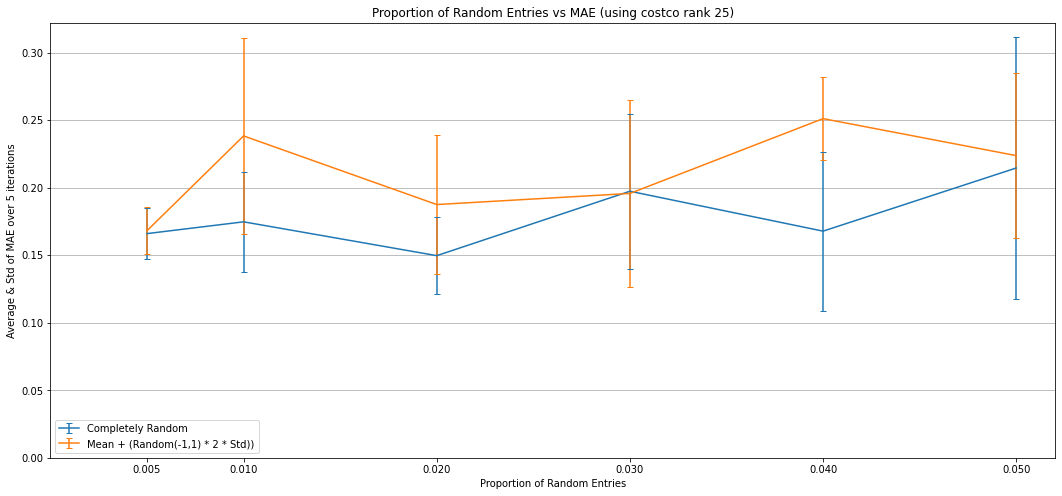

In [18]:
x = portions

plt.figure(figsize=(18, 8))

for i in range(len(avgs)):
    plt.errorbar(x, avgs[i], yerr=sds[i], label = labels[i], capsize=3)

plt.xlabel('Proportion of Random Entries')
plt.ylabel(f'Average & Std of MAE over {num_iterations} iterations')
plt.title(f'Proportion of Random Entries vs MAE (using {model_type} rank {rank})')

plt.xticks([t for t in x])
plt.legend()
plt.grid(axis = 'y')

plt.xlim(0, x[-1]+(x[-1]/25))
# plt.ylim(0.1, 0.2)
# plt.ylim(0, 0.25)
plt.ylim(bottom = 0)

plt.show()